In [6]:

import json
import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import os
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [10]:
try:
    BASE_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:
    # Fallback for Jupyter or interactive mode
    BASE_DIR = os.getcwd()

file_path = os.path.join(BASE_DIR, "Data", "covtype.csv")
df = pd.read_csv(file_path)
X = df.drop('Cover_Type', axis=1)
y = df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_train_xbg = y_train - 1
y_test_xbg = y_test - 1

✅ Loaded tuned parameters for Decision Tree, Random Forest, and XGBoost

⏳ Training models...


c:\Users\Omar Ben Emad\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [22:42:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 Decision Tree Classification Report:
               precision    recall  f1-score   support

           1       0.92      0.88      0.90     42368
           2       0.90      0.94      0.92     56661
           3       0.91      0.90      0.91      7151
           4       0.85      0.78      0.82       549
           5       0.82      0.59      0.68      1899
           6       0.82      0.80      0.81      3473
           7       0.95      0.92      0.93      4102

    accuracy                           0.90    116203
   macro avg       0.88      0.83      0.85    116203
weighted avg       0.90      0.90      0.90    116203


📊 Random Forest Classification Report:
               precision    recall  f1-score   support

           1       0.97      0.95      0.96     42368
           2       0.96      0.98      0.97     56661
           3       0.95      0.97      0.96      7151
           4       0.92      0.86      0.89       549
           5       0.95      0.82      0.88      1

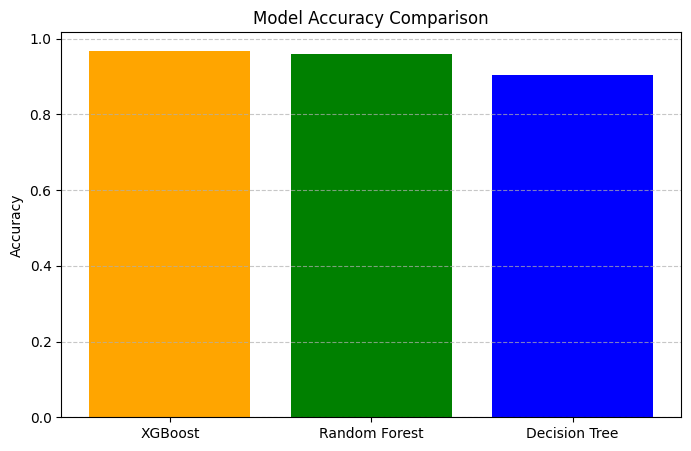


💾 Saved tuned models: Decision Tree, Random Forest, and XGBoost.


In [11]:

with open('best_dt_params.json', 'r') as f:
    dt_params = json.load(f)
with open('best_rf_params.json', 'r') as f:
    rf_params = json.load(f)
with open('best_xgb_params.json', 'r') as f:
    xgb_params = json.load(f)

print('✅ Loaded tuned parameters for Decision Tree, Random Forest, and XGBoost')


dt_model = DecisionTreeClassifier(**dt_params, random_state=42)
rf_model = RandomForestClassifier(**rf_params, random_state=42)
xgb_model = XGBClassifier(**xgb_params, random_state=42, use_label_encoder=False, eval_metric='mlogloss')


print('\n⏳ Training models...')
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train_xbg)


models = {
    'Decision Tree': dt_model,
    'Random Forest': rf_model,
    'XGBoost': xgb_model
}

results = []

for name, model in models.items():
    # Use the correct y_test for XGBoost
    if name == 'XGBoost':
        y_pred = model.predict(X_test)
        y_true = y_test_xbg  # or y_test shifted (e.g. np.array(y_test) - 1)
    else:
        y_pred = model.predict(X_test)
        y_true = y_test

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    })
    print(f"\n📊 {name} Classification Report:\n", classification_report(y_true, y_pred))

df_results = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print('\n🏆 Model Comparison:')
print(df_results)

# Visualization
plt.figure(figsize=(8,5))
plt.bar(df_results['Model'], df_results['Accuracy'], color=['orange','green','blue'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# =============================
#Save Models
# =============================
joblib.dump(dt_model, 'final_tuned_decision_tree.pkl')
joblib.dump(rf_model, 'final_tuned_random_forest.pkl')
joblib.dump(xgb_model, 'final_tuned_xgboost.pkl')

print('\n💾 Saved tuned models: Decision Tree, Random Forest, and XGBoost.')